In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [145]:
target_idx = 3
summer_idx = 0

In [146]:
class NIOM:
    def __init__(self):
        pass
    def predict(self, X):
        preds_ave = self._average_thr(X)
        preds_ave_filter = self._filtering(preds_ave)

        preds_std = self._std_thr(X)
        preds_std_filter = self._filtering(preds_std)
        
        preds_range = self._range_thr(X)
        preds_range_filter = self._filtering(preds_range)
        
        preds_ensemble = self._ensemble(preds_ave, preds_ave_filter, preds_std, preds_std_filter, preds_range, preds_range_filter)
        return preds_ave, preds_ave_filter, preds_std, preds_std_filter, preds_range, preds_range_filter, preds_ensemble

    def _ensemble(self, preds_ave, preds_ave_filter, preds_std, preds_std_filter, preds_range, preds_range_filter):
        preds_ave = pd.DataFrame({"preds": preds_ave})
        preds_std = pd.DataFrame({"preds": preds_std})
        preds_range = pd.DataFrame({"preds": preds_range})

        preds_ave["preds"] = preds_ave.preds.fillna(1).apply(int)
        preds_ave_filter["preds"] = preds_ave_filter.preds.fillna(1).apply(int)
        preds_std["preds"] = preds_std.preds.fillna(1).apply(int)
        preds_std_filter["preds"] = preds_std_filter.preds.fillna(1).apply(int)
        preds_range["preds"] = preds_range.preds.fillna(1).apply(int)
        preds_range_filter["preds"] = preds_range_filter.preds.fillna(1).apply(int)
        return preds_ave|preds_ave_filter|preds_std|preds_std_filter|preds_range|preds_range_filter

    def _filtering(self, preds):
        df = pd.DataFrame()
        df["preds"] = preds
        df["preds"] = df.preds.rolling(15).apply(lambda window: 1 if window.sum() >=2 else 0)
        return df

    def _std_thr(self, X):
        X["Energy"] = X.Energy.rolling(15).std()
        return self._threshold(X)
     
    def _average_thr(self, X):
        X["Energy"] = X.Energy.rolling(15).mean()
        return self._threshold(X)
    
    def _range_thr(self, X):
        X["Energy"] = X.Energy.rolling(15).max()
        X["Energy"] -= X.Energy.rolling(15).min()
        return self._threshold(X)

    def _threshold(self, X):
        preds = []
        for _, ser in X.groupby("Day"):
            energy_night = ser[(ser.Time > 1)&(ser.Time < 8)].Energy
            p_ave = energy_night.max()
            # print(f"p_ave: {p_ave}")

            energy_day = ser[(ser.Time >= 12)&(ser.Time < 44)].Energy
            pred = [1 if x > p_ave else 0 for x in energy_day]
            preds += pred      
        return preds

In [147]:
target_X_all = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_X_train_niom.csv")
num_days = int(target_X_all.shape[0]/48)
target_X_all["Day"] = [i for i in range (num_days) for _ in range(48)]

target_X = target_X_all[(target_X_all.Time >= 12)&(target_X_all.Time < 44)]
target_X = target_X.reset_index(drop=True)
target_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_Y_train_niom.csv")[target_X.Season==summer_idx]

target_X_all = target_X_all[target_X_all.Season==summer_idx]

In [148]:
niom = NIOM()
pred_y_ave, pred_y_ave_filtered, pred_y_std, pred_y_std_filtered, pred_y_range, pred_y_range_filtered, pred_y_ensemble  = niom.predict(target_X_all)

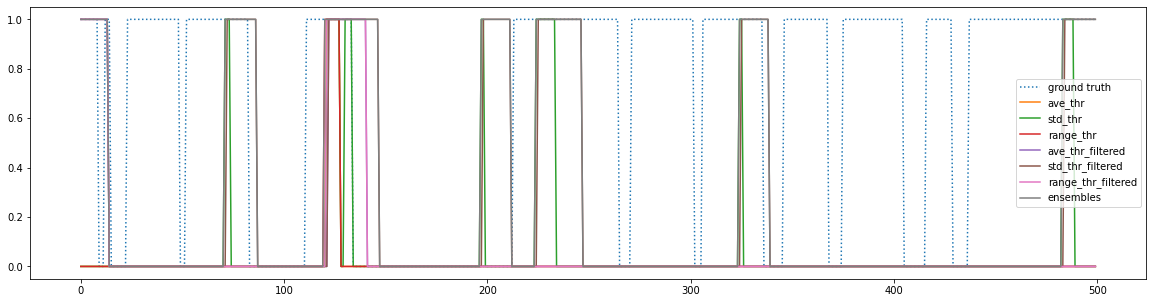

In [149]:
plt.figure(figsize=(20, 5))
plt.plot(target_y_task.reset_index().Occupancy[:500], ":", label="ground truth")
plt.plot(pred_y_ave[:500], label="ave_thr")
plt.plot(pred_y_std[:500], label="std_thr")
plt.plot(pred_y_range[:500], label="range_thr")

plt.plot(pred_y_ave_filtered[:500], label="ave_thr_filtered")
plt.plot(pred_y_std_filtered[:500], label="std_thr_filtered")
plt.plot(pred_y_range_filtered[:500], label="range_thr_filtered")
plt.plot(pred_y_ensemble[:500], label="ensembles")
plt.legend()

In [150]:
sum(pred_y_ensemble.values.reshape(-1)==target_y_task.reset_index().Occupancy.values)/pred_y_ensemble.shape[0]

0.4357638888888889